In [1]:
# %%
# Author: Kai Chen
# Institute: INS, SJTU
# Analyze the causal relation calculated from ECoG data.

import time
import numpy as np
import matplotlib
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from fcpy.core import EcogTDMI

In [46]:
def gen_sc_fc_figure(tdmi_flatten:dict, 
                     weight_flatten:dict,
                     dist_flatten:dict,
                     tdmi_threshold:float, 
                     snr_mask:dict=None,
                     is_log:bool=True,
                     )->plt.Figure:
    """Generated figure for analysis of causal distributions.

    Args:
        tdmi_flatten (np.ndarray): flattened data for target tdmi statistics.
        weight_flatten (np.ndarray): flattened data for true connectome.
        tdmi_threshold (float): significance value of tdmi statistics.

    Returns:
        plt.Figure: matplotlib.figure.Figure
    """
    # create figure canvas
    fig = plt.figure(figsize=(9,15), dpi=100)
    gs = fig.add_gridspec(nrows=4, ncols=2, 
                          left=0.02, right=0.96, top=0.96, bottom=0.05, 
                          wspace=0.20, hspace=0.20)
    ax = np.array([fig.add_subplot(i, projection='3d', azim=45, elev=10) for i in gs])

    if snr_mask is None:
        snr_mask = {}
        for band, value in tdmi_flatten.items():
            snr_mask[band] = np.ones_like(value).astype(bool)
    for idx, band in enumerate(tdmi_flatten.keys()):
        if is_log:
            log_tdmi_data = np.log10(tdmi_flatten[band])
        else:
            log_tdmi_data = tdmi_flatten[band].copy()

        weight_set = np.unique(weight_flatten[band])
        log_tdmi_data_buffer = log_tdmi_data.copy()
        log_tdmi_data_buffer[~snr_mask[band]] = np.nan
        log_tdmi_data_mean = np.array([np.nanmean(log_tdmi_data_buffer[weight_flatten[band]==key]) for key in weight_set])
        log_tdmi_data_mean[weight_set==0]=np.nan
        weight_set[weight_set==0]=np.nan
        coef_mat = np.vstack((np.log10(weight_flatten[band]+1e-6)[~np.isnan(log_tdmi_data_buffer)], np.log10(dist_flatten[band])[~np.isnan(log_tdmi_data_buffer)])).T
        coef_mat = np.hstack((coef_mat, np.ones((coef_mat.shape[0], 1))))
        b = log_tdmi_data_buffer[~np.isnan(log_tdmi_data_buffer)]
        pval,_,_,_ = np.linalg.lstsq(
            coef_mat,b
        )
        # pval = np.polyfit(np.log10(weight_set), log_tdmi_data_mean, deg=1)
        # pval = np.polyfit(np.log10(weight_set)[~np.isnan(log_tdmi_data_mean)], log_tdmi_data_mean[~np.isnan(log_tdmi_data_mean)], deg=1)
        # pval = np.polyfit(np.log10(weight_flatten+1e-6)[~np.isnan(log_tdmi_data_buffer)], log_tdmi_data_buffer[~np.isnan(log_tdmi_data_buffer)], deg=1)
        # ax[idx].plot3D(np.log10(weight_flatten[band]+1e-6), np.log10(dist_flatten[band]), log_tdmi_data.flatten(), 'k.', label='TDMI samples')
        ax[idx].plot3D(np.log10(weight_flatten[band]+1e-6), np.log10(dist_flatten[band]), log_tdmi_data_buffer, 'b.', label='TDMI (above SNR th)')
        x_range = ax[idx].get_xticks()
        y_range = ax[idx].get_yticks()
        xx, yy = np.meshgrid(x_range,y_range)
        ax[idx].plot_surface(xx, yy, xx * pval[0] + yy * pval[1] + pval[2], alpha=.0, edgecolors='r')
        # ax[idx].plot3D(np.log10(weight_set), np.log10(dist_flatten[band]), log_tdmi_data_mean, 'm.', label='TDMI mean')
        # ax[idx].plot(np.log10(weight_set), np.polyval(pval, np.log10(weight_set)), 'r', label='Linear Fitting')

        # ax[idx].set_xlabel(r'$log_{10}$(Connectivity Strength)')
        # weight_flatten_buffer = weight_flatten[band].copy()
        # weight_flatten_buffer[weight_flatten_buffer==0] = np.nan
        ax[idx].set_title('r = %5.3f' % 
            Linear_R2(np.log10(weight_flatten[band]), np.log10(dist_flatten[band]), log_tdmi_data_buffer, pval)**0.5,
            fontsize=16
        )

    return fig



In [47]:
def Linear_R2(x:np.ndarray, y:np.ndarray, z:np.ndarray, pval:np.ndarray)->float:
    """Compute R-square value for linear fitting.

    Args:
        x (np.ndarray): variable 1 of function
        y (np.ndarray): variable 2 of function
        y (np.ndarray): image of function
        pval (np.ndarray): parameter of linear fitting

    Returns:
        float: R square value
    """
    mask = ~np.isnan(x)*~np.isnan(y)*~np.isnan(z)*~np.isinf(x)*~np.isinf(y)*~np.isinf(z)# filter out nan
    z_predict = x[mask]*pval[0]+y[mask]*pval[1] + pval[2]
    R = np.corrcoef(z[mask], z_predict)[0,1]
    return R**2

<IPython.core.display.Javascript object>


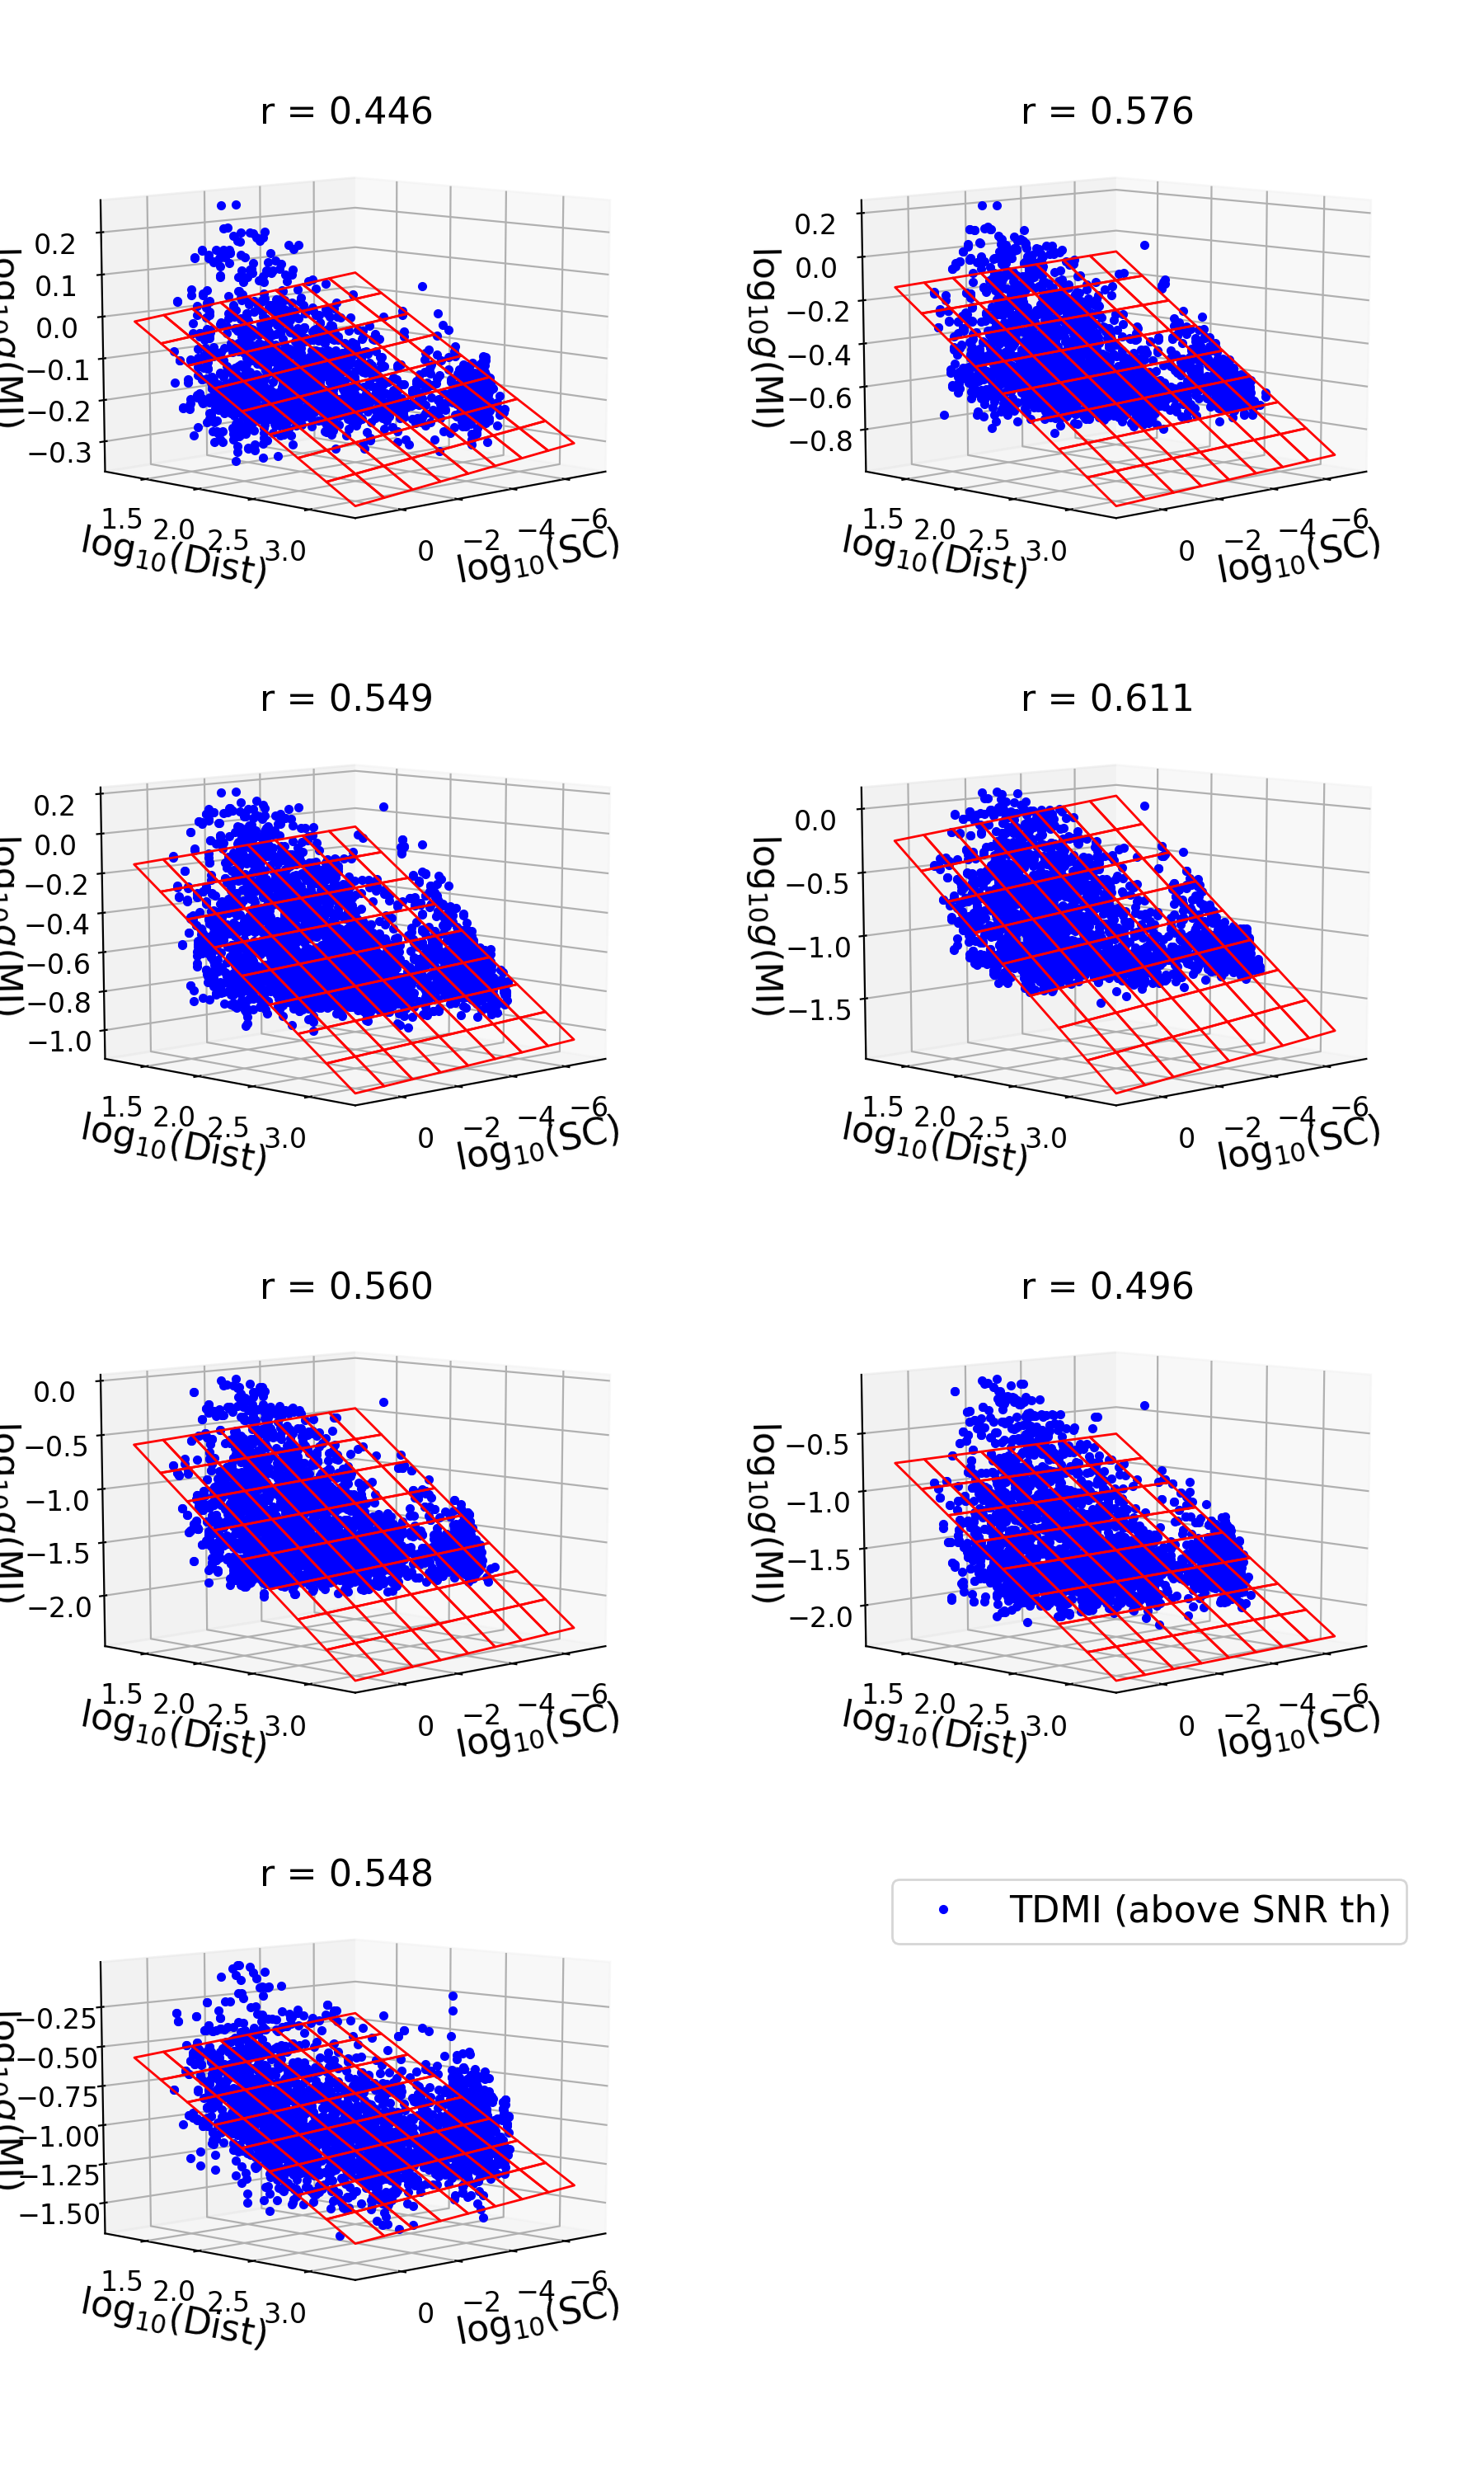

/Users/kchen/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/Users/kchen/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/kchen/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log10
/Users/kchen/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/Users/kchen/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we ad

(0.0, 1.0, 0.0, 1.0)

In [48]:
arg_default = {
    'path': 'tdmi_snr_analysis/',
    'is_interarea': False,
}
start = time.time()

# Load SC and FC data
# ==================================================
data = EcogTDMI('data/')
data.init_data(arg_default['path'])
data_package = np.load('data/preprocessed_data.npz', allow_pickle=True)
dist_mat = data_package['d_matrix']
sc, fc = data.get_sc_fc('ch')
snr_mask = data.get_snr_mask(arg_default['path'])
roi_mask = data.roi_mask.copy()
# ==================================================

d_mat = {}
for band in data.filters:
    # setup interarea mask
    d_mat[band] = dist_mat[roi_mask]
fig = gen_sc_fc_figure(fc, sc, d_mat, tdmi_threshold=None,snr_mask=snr_mask)
ax = fig.get_axes()
[axi.set_xlabel(r'$\log_{10}$(SC)') for axi in ax]
[axi.set_ylabel(r'$\log_{10}$(Dist)') for axi in ax]
[axi.set_zlabel(r'$\log_{10}g$(MI)') for axi in ax]
# [ax[i].get_lines()[2].set_color((0,0,0,0)) for i in range(7)]
handles, labels = ax[0].get_legend_handles_labels()
ax[-1].legend(handles, labels)
ax[-1].axis('off')

# fname = f'ch_analysis_mi_snr_reg.png'
# fig.savefig(arg_default['path'] + fname)
# plt.close(fig)


# %%
